In [123]:
from qiskit import QuantumCircuit, QuantumRegister
import os, sys
import numpy
import random
from tqdm import tqdm
import rustworkx

if not '../' in sys.path:
    sys.path.insert(1, '../')

In [124]:
d = os.getcwd()
print(d)
print(sys.path)

/home/ashutosh/Desktop/Uncomputation-Code/eval_notebooks
['/usr/lib/python310.zip', '../', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/home/ashutosh/.local/lib/python3.10/site-packages', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages']


In [125]:
valid_num_circuits = 10

In [126]:
from helperfunctions.circuitgraphfunctions import get_computation_graph, get_uncomp_circuit
from helperfunctions.uncompfunctions import add_uncomputation, exhaustive_uncomputation_adding, greedy_uncomputation_full, greedy_uncomputation_partial
from helperfunctions.graphhelper import edge_attr, edge_matcher,node_attr,node_matcher, breakdown_qubit
from helperfunctions.measurecircuit import get_statevector, get_probability_from_statevector, zero_ancillas_in_statevector
from helperfunctions.constants import UncompType

In [127]:
def random_quantum_circuit_large_distinct_nums(num_q, num_a) -> tuple[QuantumCircuit,int,int,int]:
    
    # num_q = random.randint(3,10)
    # num_a = random.randint(3,10)
    # num_g = random.randint(50, 100)
    # num_g = random.randint(10,50)
    num_g = 25

    cc_gates = 0
    ca_gates = 0
    ac_gates = 0
    aa_gates = 0
    
    in_q = QuantumRegister(num_q, name='cq')
    an_q = QuantumRegister(num_a, name='aq')
    
    circuit = QuantumCircuit(in_q, an_q)

    for q in in_q:
        circuit.x(q)
        circuit.h(q)
    
    for i in tqdm(range(num_g), desc=f'Building Random Quantum Circuit with {num_q}q, {num_a}a, {num_g}g'):

        control_q = in_q
        target_q = in_q

        change_target_controls = random.random()

        if change_target_controls > 0.8: # Input acts on Input only    
            control_q = an_q
            target_q = an_q
            aa_gates += 1

        elif change_target_controls > 0.4: 
            # control_q = in_q
            if random.random() > 0.5:
                target_q = an_q
                ca_gates += 1
            else:
                control_q = an_q
                ac_gates += 1

        else:
            cc_gates += 1 
            

        num_controls = random.randrange(1, control_q.size)
        target = random.randrange(target_q.size) # Get target qubit
        controls = random.sample(range(control_q.size), num_controls)  # Get control qubit/s
        # target = random.randrange(target_q.size) # Get target qubit
        if control_q == target_q:
            target = random.randrange(target_q.size) # Get target qubit
            valid_controls = list(range(control_q.size))
            valid_controls.remove(target)
            controls = random.sample(valid_controls, num_controls)  # Get control qubit/s
        else:
            target = random.randrange(target_q.size) # Get target qubit
            controls = random.sample(range(control_q.size), num_controls)  # Get control qubit/s
        
        # print(num_controls, controls, target)
        circuit.mcx([control_q[cq] for cq in controls],target_q[target]) 

    # logger.info(f'Built circuit with {num_q} input, {num_a} ancilla and {num_g} gates.')
    # logger.info(f'There are {cc_gates} gates acting between control qubits, {ca_gates} gates acting between control and ancilla, {ac_gates} gates acting between ancilla and control and {aa_gates} gates acting between just the ancillas.')
    print(f'Built circuit with {num_q} input, {num_a} ancilla and {num_g} gates.')
    print(f'There are {cc_gates} gates acting between control qubits, {ca_gates} gates acting between control and ancilla, {ac_gates} gates acting between ancilla and control and {aa_gates} gates acting between just the ancillas.')
    
    return circuit, num_q, num_a, num_g

def get_eval_results(comp_circuit: QuantumCircuit, uncomp_circuit:QuantumCircuit, num_a):
    eq4_comp_statevector = get_statevector(comp_circuit)
    eq4_comp_prob_dist = get_probability_from_statevector(eq4_comp_statevector)
    # logger.info(f'Comp Circuit {name_str} Eq4 Probability Distribution: \n{print_probs(eq4_comp_prob_dist)}')

    eq5_comp_statevector = zero_ancillas_in_statevector(eq4_comp_statevector, num_a)
    eq5_comp_prob_dist = get_probability_from_statevector(eq5_comp_statevector)
    # logger.info(f'Comp Circuit {name_str} Eq5 Probability Distribution: \n{print_probs(eq5_comp_prob_dist)}')

    eq4_uncomp_statevector = get_statevector(uncomp_circuit)
    eq4_uncomp_prob_dist = get_probability_from_statevector(eq4_uncomp_statevector)
    # logger.info(f'{uncomp_type.capitalize()} Uncomp Circuit {name_str} Eq4 Probability Distribution: \n{print_probs(eq4_uncomp_prob_dist)}')

    distance_probs_eq5_4_comp = numpy.linalg.norm(eq5_comp_prob_dist - eq4_comp_prob_dist)
    distance_probs_eq5_4_uncomp = numpy.linalg.norm(eq4_uncomp_prob_dist - eq5_comp_prob_dist)
    
    distance_probs_eq5_4_comp, distance_probs_eq5_4_uncomp = numpy.round((distance_probs_eq5_4_comp, distance_probs_eq5_4_uncomp), decimals=10)

    return distance_probs_eq5_4_comp, distance_probs_eq5_4_uncomp, eq4_comp_prob_dist, eq5_comp_prob_dist, eq4_uncomp_prob_dist


    


In [128]:
class ProbDiffResults:
    def __init__(self):
        self.exhaustive_comp_diff = numpy.zeros(valid_num_circuits)
        self.exhaustive_uncomp_diff = numpy.zeros(valid_num_circuits)
        self.exhaustive_eq4 = numpy.zeros(valid_num_circuits)
        self.exhaustive_eq5 = numpy.zeros(valid_num_circuits)
        self.exhaustive_uncomp = numpy.zeros(valid_num_circuits)
        

        self.greedy_full_comp_diff = numpy.zeros(valid_num_circuits)
        self.greedy_full_uncomp_diff = numpy.zeros(valid_num_circuits)
        self.greedy_full_eq4 = numpy.zeros(valid_num_circuits)
        self.greedy_full_eq5 = numpy.zeros(valid_num_circuits)
        self.greedy_full_uncomp = numpy.zeros(valid_num_circuits)
        
        self.greedy_partial_comp_diff = numpy.zeros(valid_num_circuits)
        self.greedy_partial_uncomp_diff = numpy.zeros(valid_num_circuits)        
        self.greedy_partial_eq4 = numpy.zeros(valid_num_circuits)
        self.greedy_partial_eq5 = numpy.zeros(valid_num_circuits)
        self.greedy_partial_uncomp = numpy.zeros(valid_num_circuits)

        self.regular_comp_diff = numpy.zeros(valid_num_circuits)
        self.regular_uncomp_diff = numpy.zeros(valid_num_circuits)
        self.regular_eq4 = numpy.zeros(valid_num_circuits)
        self.regular_eq5 = numpy.zeros(valid_num_circuits)
        self.regular_uncomp = numpy.zeros(valid_num_circuits)

    def add_to_exhaustive(self, comp_diff, uncomp_diff, eq4, eq5, uncomp, idx):
        # numpy.append(self.exhaustive_uncomp_diff, comp)
        # numpy.append(self.exhaustive_uncomp_diff, uncomp)
        self.exhaustive_comp_diff[idx] = comp_diff
        self.exhaustive_uncomp_diff[idx] = uncomp_diff
        # self.exhaustive_eq4[idx] = eq4
        # self.exhaustive_eq5[idx] = eq5
        # self.exhaustive_uncomp[idx] = uncomp


    def add_to_greedy_partial(self, comp_diff, uncomp_diff, eq4, eq5, uncomp, idx):
        # numpy.append(self.exhaustive_uncomp_diff, comp)
        # numpy.append(self.exhaustive_uncomp_diff, uncomp)
        self.greedy_partial_comp_diff[idx] = comp_diff
        self.greedy_partial_uncomp_diff[idx] = uncomp_diff
        # self.greedy_partial_eq4[idx] = eq4
        # self.greedy_partial_eq5[idx] = eq5
        # self.greedy_partial_uncomp[idx] = uncomp
    
    def add_to_greedy_full(self, comp_diff, uncomp_diff, eq4, eq5, uncomp, idx):
        # numpy.append(self.exhaustive_uncomp_diff, comp)
        # numpy.append(self.exhaustive_uncomp_diff, uncomp)
        self.greedy_full_comp_diff[idx] = comp_diff
        self.greedy_full_uncomp_diff[idx] = uncomp_diff
        # self.greedy_full_eq4[idx] = eq4
        # self.greedy_full_eq5[idx] = eq5
        # self.greedy_full_uncomp[idx] = uncomp
    
    def add_to_regular(self, comp_diff, uncomp_diff, eq4, eq5, uncomp, idx):
        # numpy.append(self.exhaustive_uncomp_diff, comp)
        # numpy.append(self.exhaustive_uncomp_diff, uncomp)
        self.regular_comp_diff[idx] = comp_diff
        self.regular_uncomp_diff[idx] = uncomp_diff
        # self.regular_eq4[idx] = eq4
        # self.regular_eq5[idx] = eq5
        # self.regular_uncomp[idx] = uncomp

    def __str__(self):
        return f'''
                Exhaustive Comp Avg:\t\t{numpy.average(self.exhaustive_comp_diff)}
                Exhaustive UnComp Avg:\t\t{numpy.average(self.exhaustive_uncomp_diff)}
                Greedy Full Comp Avg:\t\t{numpy.average(self.greedy_full_comp_diff)}
                Greedy Full UnComp Avg:\t\t{numpy.average(self.greedy_full_uncomp_diff)}
                Greedy Partial Comp Avg:\t{numpy.average(self.greedy_partial_comp_diff)}
                Greedy Partial UnComp Avg:\t{numpy.average(self.greedy_partial_uncomp_diff)}
                Regular Comp Avg:\t\t{numpy.average(self.regular_comp_diff)}
                Regular UnComp Avg:\t\t{numpy.average(self.regular_uncomp_diff)}
                '''

        

In [129]:

def get_circuit_metrics(num_q, num_a, results:ProbDiffResults):
    print('****************************************************************************')
    for idx in range(valid_num_circuits):
        # if num_circuits > 0:

        #     logger.info(f'Generating Random Circuit {i}')
        #     # _circuit, num_q, num_a, num_g = random_quantum_circuit_basic()
        #     _circuit, num_q, num_a, num_g = random_quantum_circuit_large()

        # else:
        #     _circuit, num_q, num_a, num_g = simple_circuit_with_partial_uncomp()

        _circuit, num_q, num_a, num_g = random_quantum_circuit_large_distinct_nums(num_q,num_a)
            

        name_str = f'Circuit_{idx}'

        # _circuit.draw('mpl', 
        #                 filename=f'{eval_dir}/comp_circuit/{name_str}.png')
        
        # with open(f'{eval_dir}/comp_circuit_qpy/{name_str}.qpy', 'wb') as f:
        #     qpy.dump(_circuit, f)
        #     f.close()
        
        # logger.info(f'Building Random Circuit took {time.time_ns()-start_time} ns')
        # start_time = time.time_ns()
        # logger.info(f'Creating Circuit Graph of circuit {name_str}')
        ancillas_list = [breakdown_qubit(q)['label'] for q in _circuit.qubits][-num_a:]
        _circuit_graph = get_computation_graph(_circuit, ancillas_list)

        # graphviz_draw(_circuit_graph,
        #               node_attr_fn=node_attr,
        #               edge_attr_fn=edge_attr,
        #               filename=f'{eval_dir}/comp_circuit_graph/{name_str}.png')

        # logger.info(f'Building Circuit Graph took {time.time_ns()-start_time} ns')
        # start_time = time.time_ns()
        
        if rustworkx.digraph_find_cycle(_circuit_graph):
            # print(f'Computation Graph has cycles !!!!')
            # logger.error(f'Computation Circuit Graph for circuit {name_str} has cycles!!')
            for cycle in rustworkx.simple_cycles(_circuit_graph):
                print(cycle)
                # logger.error(f'Cycle in {name_str} : {cycle}')

        # logger.info(f'Checking for cycle in Comp Circuit Graph took {time.time_ns()-start_time} ns')
        # start_time = time.time_ns()
        
        _regular_uncomp_circuit_graph, has_cycle = add_uncomputation(_circuit_graph, ancillas_list)

        # logger.info(f'Adding Uncomputation to circuit graph took {time.time_ns()-start_time} ns')
        # start_time = time.time_ns()

        if has_cycle:
            # logger.warning(f'Trying to uncompute circuit {name_str} produces a cycle')

            # logger.info(f'Attempting to run exhaustive uncomp on {name_str}')
            largest_set = exhaustive_uncomputation_adding(_circuit_graph, ancillas_list)
            print(f'Largest Set of ancilla for {name_str} that can be uncomputed is {largest_set}')
            # logger.info(f'Time to find largest set took {time.time_ns()-start_time} ns')
            # start_time = time.time_ns()
            _exhaustive_uncomp_circuit_graph, has_cycle = add_uncomputation(_circuit_graph, list(largest_set))
            if has_cycle:
                print(f'Exhaustive Uncomp of {name_str} still has cycle')
            
            # logger.info(f'Drawing Exhaustive Uncomp Circuit Graph for {name_str}')
            # graphviz_draw(_exhaustive_uncomp_circuit_graph,
            #           node_attr_fn=node_attr,
            #           edge_attr_fn=edge_attr,
            #           filename=f'{eval_dir}/exhaustive_uncomp_graph/{name_str}.png')

            # logger.info(f'Adding Uncomp for largest set took {time.time_ns()-start_time} ns')
            # start_time = time.time_ns()

            # logger.info(f'Building Exhaustive Uncomp Circuit for {name_str}')
            _exhaustive_uncomp_circuit = get_uncomp_circuit(_exhaustive_uncomp_circuit_graph)
            # _exhaustive_uncomp_circuit.draw('mpl', filename=f'{eval_dir}/exhaustive_uncomp_circuit/{name_str}.png')

            # logger.info(f'Time to build uncomp circuit took {time.time_ns()-start_time} ns')
            # start_time = time.time_ns()

            
            # evaluate_circuits(comp_circuit=_circuit, 
            #                     uncomp_circuit=_exhaustive_uncomp_circuit, 
            #                     num_a=num_a, name_str=name_str, metric=metrics, uncomp_type=UncompType.EXHAUSTIVE)

            ex_vals = get_eval_results(_circuit, _exhaustive_uncomp_circuit, num_a)

            # print(f'Exhaustive Prob Diff for {name_str}: Uncomp: {uncomp_prob_diff}: Comp: {comp_prob_diff}')
            
            results.add_to_exhaustive(*ex_vals, idx=idx)

            # with open(f'{eval_dir}/exhaustive_uncomp_circuit_qpy/{name_str}.qpy', 'wb') as f:
            #     qpy.dump(_exhaustive_uncomp_circuit, f)
            #     f.close()
            

    # ***************************************************************************************************************#
            # logger.info(f'Attempting to run greedy uncomp on {name_str}')
            _greedy_uncomp_circuit_graph = greedy_uncomputation_full(_circuit_graph, ancillas_list, max_cycles=5*(10**5))
            
            # logger.info(f'Drawing Greedy Uncomp Circuit Graph for {name_str}')
            # graphviz_draw(_greedy_uncomp_circuit_graph,
            #           node_attr_fn=node_attr,
            #           edge_attr_fn=edge_attr,
            #           filename=f'{eval_dir}/greedy_uncomp_graph/{name_str}.png')

            # logger.info(f'Building Greedy Uncomp Circuit for {name_str}')
            _greedy_uncomp_circuit = get_uncomp_circuit(_greedy_uncomp_circuit_graph)
            # _greedy_uncomp_circuit.draw('mpl', filename=f'{eval_dir}/greedy_uncomp_circuit/{name_str}.png')


            # evaluate_circuits(comp_circuit=_circuit, 
            #                     uncomp_circuit=_greedy_uncomp_circuit, 
            #                     num_a=num_a, name_str=name_str, metric=metrics, uncomp_type=UncompType.GREEDY_FULL)
            
            gf_vals = get_eval_results(_circuit, _greedy_uncomp_circuit, num_a)
            
            results.add_to_greedy_full(*gf_vals, idx=idx)

            # print(f'Greedy-Full Prob Diff for {name_str}: Uncomp: {uncomp_prob_diff}: Comp: {comp_prob_diff}')

            # with open(f'{eval_dir}/greedy_uncomp_circuit_qpy/{name_str}.qpy', 'wb') as f:
            #     qpy.dump(_greedy_uncomp_circuit, f)
            #     f.close()
            

    #**************************************************************************************************************#
            print(f'Comparing the uncomp circuit grapphs by greedy and exhaustive for {name_str}')
            if rustworkx.is_isomorphic(_greedy_uncomp_circuit_graph, _exhaustive_uncomp_circuit_graph,
                                        node_matcher=node_matcher, edge_matcher=edge_matcher):
                print(f'Both methods return the same circuit graphs')
                # metrics.greedy_and_exhaustive_return_same += 1
            else:
                print(f'Both methods return different circuit graphs')

    #**************************************************************************************************************#
            # logger.info(f'Attempting to run greedy partial uncomp on {name_str}')
            _greedy_partial_uncomp_circuit_graph = greedy_uncomputation_partial(_circuit_graph, ancillas_list, max_cycles=5*(10**5))
            
            # logger.info(f'Drawing Greedy Partial Uncomp Circuit Graph for {name_str}')
            # graphviz_draw(_greedy_partial_uncomp_circuit_graph,
            #           node_attr_fn=node_attr,
            #           edge_attr_fn=edge_attr,
            #           filename=f'{eval_dir}/greedy_partial_uncomp_graph/{name_str}.png')

            # logger.info(f'Building Greedy Partial Uncomp Circuit for {name_str}')
            _greedy_partial_uncomp_circuit = get_uncomp_circuit(_greedy_partial_uncomp_circuit_graph)
            # _greedy_partial_uncomp_circuit.draw('mpl', filename=f'{eval_dir}/greedy_partial_uncomp_circuit/{name_str}.png')

            # evaluate_circuits(comp_circuit=_circuit, 
            #                     uncomp_circuit=_greedy_partial_uncomp_circuit, 
            #                     num_a=num_a, name_str=name_str, metric=metrics, uncomp_type=UncompType.GREEDY_PARTIAL) 

            gp_vals = get_eval_results(_circuit, _greedy_partial_uncomp_circuit, num_a)
            
            results.add_to_greedy_partial(*gp_vals, idx=idx)
            # with open(f'{eval_dir}/greedy_partial_uncomp_circuit_qpy/{name_str}.qpy', 'wb') as f:
            #     qpy.dump(_greedy_partial_uncomp_circuit, f)
            #     f.close()


            # print(f'Greedy-Partial Prob Diff for {name_str}: Uncomp: {uncomp_prob_diff}: Comp: {comp_prob_diff}')
    #**************************************************************************************************************#
        else:
            # logger.info(f'Drawing Regular Uncomp Circuit Graph for {name_str}')
            # graphviz_draw(_regular_uncomp_circuit_graph,
            #           node_attr_fn=node_attr,
            #           edge_attr_fn=edge_attr,
            #           filename=f'{eval_dir}/regular_uncomp_graph/{name_str}.png')
            
            # logger.info(f'Building Regular Uncomp Circuit for {name_str}')
            _uncomp_circuit = get_uncomp_circuit(_regular_uncomp_circuit_graph)
            # _uncomp_circuit.draw('mpl', filename=f'{eval_dir}/regular_uncomp_circuit/{name_str}.png')

            # evaluate_circuits(comp_circuit=_circuit, 
            #                     uncomp_circuit=_uncomp_circuit, 
            #                     num_a=num_a, name_str=name_str, metric=metrics, uncomp_type=UncompType.REGULAR)
            
            # metrics.can_be_regularly_uncomputed += 1
            reg_vals = get_eval_results(_circuit, _uncomp_circuit, num_a)
            
            results.add_to_regular(*reg_vals, idx=idx)
            # with open(f'{eval_dir}/regular_uncomp_circuit_qpy/{name_str}.qpy', 'wb') as f:
            #     qpy.dump(_uncomp_circuit, f)
            #     f.close()

            # print(f'Regular Prob Diff for {name_str}: Uncomp: {uncomp_prob_diff}: Comp: {comp_prob_diff}')
    return results


In [110]:
num_q = 5
results_dict = {}
for idx in range(3,10):
    results = ProbDiffResults()
    filled_results = get_circuit_metrics(num_q, idx, results)
    print(filled_results)
    results_dict.update({idx: filled_results})
    

****************************************************************************


Building Random Quantum Circuit with 5q, 3a, 25g: 100%|██████████| 25/25 [00:00<00:00, 10388.11it/s]


Built circuit with 5 input, 3 ancilla and 25 gates.
There are 12 gates acting between control qubits, 5 gates acting between control and ancilla, 3 gates acting between ancilla and control and 5 gates acting between just the ancillas.


Adding Uncomputation Nodes:  33%|███▎      | 14/43 [00:00<00:00, 67417.06it/s]
Iterating over powerset of ancillas: 8it [00:00, 51.87it/s]


Largest Set of ancilla for Circuit_0 that can be uncomputed is ()


Iterating over all cycles in graph:   9%|▉         | 46671/500000 [00:00<00:02, 153629.10it/s]


aq0 216486


Iterating over all cycles in graph:   0%|          | 946/500000 [00:00<00:02, 222510.74it/s]


aq1 1719


Iterating over all cycles in graph:   0%|          | 23/500000 [00:00<00:04, 124798.18it/s]


aq2 46


Building uncomp circuit from circuit graph: 100%|██████████| 43/43 [00:00<00:00, 29230.97it/s]


Comparing the uncomp circuit grapphs by greedy and exhaustive for Circuit_0
Both methods return the same circuit graphs


Iterating over all cycles:   9%|▉         | 46671/500000 [00:00<00:03, 120180.25it/s]


aq0 216486


Building Random Quantum Circuit with 5q, 3a, 25g: 100%|██████████| 25/25 [00:00<00:00, 13263.04it/s]


Built circuit with 5 input, 3 ancilla and 25 gates.
There are 7 gates acting between control qubits, 3 gates acting between control and ancilla, 9 gates acting between ancilla and control and 6 gates acting between just the ancillas.


Adding Uncomputation Nodes:  16%|█▋        | 7/43 [00:00<00:00, 31367.66it/s]
Iterating over powerset of ancillas: 8it [00:00, 254.49it/s]


Largest Set of ancilla for Circuit_1 that can be uncomputed is ()


Iterating over all cycles in graph:   1%|          | 4467/500000 [00:00<00:01, 274801.35it/s]


aq1 6997


Iterating over all cycles in graph:   0%|          | 1042/500000 [00:00<00:02, 218032.66it/s]


aq2 2457


Iterating over all cycles in graph:   0%|          | 14/500000 [00:00<00:03, 147909.96it/s]


aq0 41


Building uncomp circuit from circuit graph: 100%|██████████| 43/43 [00:00<00:00, 45601.79it/s]


Comparing the uncomp circuit grapphs by greedy and exhaustive for Circuit_1
Both methods return the same circuit graphs


Iterating over all cycles:   1%|          | 4467/500000 [00:00<00:02, 211014.26it/s]


aq1 6997


Iterating over all cycles:   1%|          | 4467/500000 [00:00<00:02, 210150.37it/s]


aq1 6997


Iterating over all cycles:   0%|          | 564/500000 [00:00<00:02, 213423.62it/s]


aq0 1030


Iterating over all cycles:   0%|          | 188/500000 [00:00<00:02, 209826.81it/s]


aq2 350


Building Random Quantum Circuit with 5q, 3a, 25g: 100%|██████████| 25/25 [00:00<00:00, 11658.62it/s]


Built circuit with 5 input, 3 ancilla and 25 gates.
There are 7 gates acting between control qubits, 10 gates acting between control and ancilla, 5 gates acting between ancilla and control and 3 gates acting between just the ancillas.


Adding Uncomputation Nodes:   7%|▋         | 3/43 [00:00<00:00, 29888.15it/s]
Iterating over powerset of ancillas: 8it [00:00, 264.49it/s]


Largest Set of ancilla for Circuit_2 that can be uncomputed is ()


Iterating over all cycles in graph:  11%|█         | 53412/500000 [00:00<00:03, 139746.64it/s]


aq2 270656


Iterating over all cycles in graph:   0%|          | 1013/500000 [00:00<00:02, 221143.49it/s]


aq0 3363


Iterating over all cycles in graph:   0%|          | 5/500000 [00:00<00:05, 84222.97it/s]


aq1 13


Building uncomp circuit from circuit graph: 100%|██████████| 43/43 [00:00<00:00, 35081.71it/s]


Comparing the uncomp circuit grapphs by greedy and exhaustive for Circuit_2
Both methods return the same circuit graphs


Iterating over all cycles:  11%|█         | 53412/500000 [00:00<00:04, 105458.17it/s]


aq2 270656


Iterating over all cycles:   0%|          | 1063/500000 [00:00<00:02, 171199.37it/s]


aq0 3543


Building Random Quantum Circuit with 5q, 3a, 25g: 100%|██████████| 25/25 [00:00<00:00, 11598.01it/s]


Built circuit with 5 input, 3 ancilla and 25 gates.
There are 12 gates acting between control qubits, 7 gates acting between control and ancilla, 3 gates acting between ancilla and control and 3 gates acting between just the ancillas.


Adding Uncomputation Nodes:  33%|███▎      | 14/43 [00:00<00:00, 52948.83it/s]
Iterating over powerset of ancillas: 8it [00:00, 265.11it/s]


Largest Set of ancilla for Circuit_3 that can be uncomputed is ('aq2',)


Iterating over all cycles in graph:   1%|          | 3642/500000 [00:00<00:02, 238239.14it/s]


aq1 10827


Iterating over all cycles in graph:   0%|          | 354/500000 [00:00<00:02, 178288.14it/s]


aq0 792


Building uncomp circuit from circuit graph: 100%|██████████| 44/44 [00:00<00:00, 16489.40it/s]


Comparing the uncomp circuit grapphs by greedy and exhaustive for Circuit_3
Both methods return the same circuit graphs


Iterating over all cycles:   1%|          | 3642/500000 [00:00<00:02, 201568.34it/s]


aq1 10827


Building Random Quantum Circuit with 5q, 3a, 25g: 100%|██████████| 25/25 [00:00<00:00, 12977.43it/s]


Built circuit with 5 input, 3 ancilla and 25 gates.
There are 11 gates acting between control qubits, 3 gates acting between control and ancilla, 4 gates acting between ancilla and control and 7 gates acting between just the ancillas.


Adding Uncomputation Nodes:  44%|████▍     | 19/43 [00:00<00:00, 74547.97it/s]
Iterating over powerset of ancillas: 8it [00:00, 283.34it/s]


Largest Set of ancilla for Circuit_4 that can be uncomputed is ()


Iterating over all cycles in graph:  89%|████████▉ | 446562/500000 [00:02<00:00, 150918.00it/s]


aq1 1645405


Iterating over all cycles in graph:   0%|          | 1014/500000 [00:00<00:02, 206297.26it/s]


aq0 2796


Iterating over all cycles in graph:   0%|          | 7/500000 [00:00<00:04, 115137.76it/s]


aq2 13


Building uncomp circuit from circuit graph: 100%|██████████| 43/43 [00:00<00:00, 39353.06it/s]


Comparing the uncomp circuit grapphs by greedy and exhaustive for Circuit_4
Both methods return the same circuit graphs


Iterating over all cycles:  89%|████████▉ | 446562/500000 [00:03<00:00, 116327.75it/s]


aq1 1645405


Iterating over all cycles:   0%|          | 1255/500000 [00:00<00:02, 181825.61it/s]


aq0 3534


Building Random Quantum Circuit with 5q, 3a, 25g: 100%|██████████| 25/25 [00:00<00:00, 13242.94it/s]


Built circuit with 5 input, 3 ancilla and 25 gates.
There are 12 gates acting between control qubits, 2 gates acting between control and ancilla, 6 gates acting between ancilla and control and 5 gates acting between just the ancillas.


Adding Uncomputation Nodes:   9%|▉         | 4/43 [00:00<00:00, 35394.97it/s]
Iterating over powerset of ancillas: 8it [00:00, 280.75it/s]


Largest Set of ancilla for Circuit_5 that can be uncomputed is ()


Iterating over all cycles in graph:   0%|          | 26/500000 [00:00<00:02, 195433.52it/s]


aq1 70


Iterating over all cycles in graph:   0%|          | 183/500000 [00:00<00:01, 300649.29it/s]


aq0 329


Iterating over all cycles in graph:   0%|          | 90/500000 [00:00<00:01, 334948.86it/s]


aq2 90


Building uncomp circuit from circuit graph: 100%|██████████| 43/43 [00:00<00:00, 45213.10it/s]


Comparing the uncomp circuit grapphs by greedy and exhaustive for Circuit_5
Both methods return the same circuit graphs


Iterating over all cycles:   0%|          | 26/500000 [00:00<00:03, 159199.86it/s]


aq1 70


Iterating over all cycles:   0%|          | 2/500000 [00:00<00:12, 39383.14it/s]


aq1 2


Iterating over all cycles:   0%|          | 3/500000 [00:00<00:08, 55924.05it/s]


aq0 6


Building Random Quantum Circuit with 5q, 3a, 25g: 100%|██████████| 25/25 [00:00<00:00, 11908.87it/s]


Built circuit with 5 input, 3 ancilla and 25 gates.
There are 11 gates acting between control qubits, 7 gates acting between control and ancilla, 3 gates acting between ancilla and control and 4 gates acting between just the ancillas.


Adding Uncomputation Nodes:  26%|██▌       | 11/43 [00:00<00:00, 40506.89it/s]
Iterating over powerset of ancillas: 8it [00:00, 260.35it/s]


Largest Set of ancilla for Circuit_6 that can be uncomputed is ()


Iterating over all cycles in graph:  41%|████      | 203016/500000 [00:01<00:01, 190384.32it/s]


aq1 715291


Iterating over all cycles in graph:   0%|          | 1571/500000 [00:00<00:01, 264426.81it/s]


aq2 3132


Iterating over all cycles in graph:   0%|          | 5/500000 [00:00<00:05, 85948.85it/s]


aq0 14


Building uncomp circuit from circuit graph: 100%|██████████| 43/43 [00:00<00:00, 24131.00it/s]


Comparing the uncomp circuit grapphs by greedy and exhaustive for Circuit_6
Both methods return the same circuit graphs


Iterating over all cycles:  41%|████      | 203016/500000 [00:01<00:02, 146516.02it/s]


aq1 715291


Iterating over all cycles:   1%|          | 3039/500000 [00:00<00:02, 208214.74it/s]


aq2 5935


Iterating over all cycles:   0%|          | 57/500000 [00:00<00:02, 180843.67it/s]


aq0 146


Building Random Quantum Circuit with 5q, 3a, 25g: 100%|██████████| 25/25 [00:00<00:00, 14235.35it/s]


Built circuit with 5 input, 3 ancilla and 25 gates.
There are 6 gates acting between control qubits, 5 gates acting between control and ancilla, 8 gates acting between ancilla and control and 6 gates acting between just the ancillas.


Adding Uncomputation Nodes:  47%|████▋     | 20/43 [00:00<00:00, 85773.09it/s]
Iterating over powerset of ancillas: 8it [00:00, 279.50it/s]


Largest Set of ancilla for Circuit_7 that can be uncomputed is ()


Iterating over all cycles in graph:   1%|          | 2840/500000 [00:00<00:02, 216460.54it/s]


aq0 7724


Iterating over all cycles in graph:   0%|          | 228/500000 [00:00<00:01, 278318.19it/s]


aq1 417


Iterating over all cycles in graph:   0%|          | 10/500000 [00:00<00:03, 134003.32it/s]


aq2 37


Building uncomp circuit from circuit graph: 100%|██████████| 43/43 [00:00<00:00, 52246.54it/s]


Comparing the uncomp circuit grapphs by greedy and exhaustive for Circuit_7
Both methods return the same circuit graphs


Iterating over all cycles:   1%|          | 2840/500000 [00:00<00:03, 156862.48it/s]


aq0 7724


Iterating over all cycles:   0%|          | 198/500000 [00:00<00:02, 224573.33it/s]


aq1 366


Building Random Quantum Circuit with 5q, 3a, 25g: 100%|██████████| 25/25 [00:00<00:00, 12423.89it/s]


Built circuit with 5 input, 3 ancilla and 25 gates.
There are 11 gates acting between control qubits, 7 gates acting between control and ancilla, 5 gates acting between ancilla and control and 2 gates acting between just the ancillas.


Adding Uncomputation Nodes:   2%|▏         | 1/43 [00:00<00:00, 13797.05it/s]
Iterating over powerset of ancillas: 8it [00:00, 255.51it/s]


Largest Set of ancilla for Circuit_8 that can be uncomputed is ()


Iterating over all cycles in graph:  54%|█████▍    | 269245/500000 [00:01<00:01, 166549.25it/s]


aq0 670264


Iterating over all cycles in graph:   3%|▎         | 16000/500000 [00:00<00:02, 201053.56it/s]


aq1 43618


Iterating over all cycles in graph:   0%|          | 325/500000 [00:00<00:01, 365651.50it/s]


aq2 358


Building uncomp circuit from circuit graph: 100%|██████████| 43/43 [00:00<00:00, 33818.69it/s]


Comparing the uncomp circuit grapphs by greedy and exhaustive for Circuit_8
Both methods return the same circuit graphs


Iterating over all cycles:  54%|█████▍    | 269245/500000 [00:02<00:01, 132374.94it/s]


aq0 670264


Iterating over all cycles:   3%|▎         | 16000/500000 [00:00<00:02, 163591.18it/s]


aq1 43618


Iterating over all cycles:   0%|          | 316/500000 [00:00<00:01, 302395.63it/s]


aq2 340


Building Random Quantum Circuit with 5q, 3a, 25g: 100%|██████████| 25/25 [00:00<00:00, 11971.41it/s]


Built circuit with 5 input, 3 ancilla and 25 gates.
There are 11 gates acting between control qubits, 6 gates acting between control and ancilla, 2 gates acting between ancilla and control and 6 gates acting between just the ancillas.


Adding Uncomputation Nodes:  40%|███▉      | 17/43 [00:00<00:00, 56366.14it/s]
Iterating over powerset of ancillas: 8it [00:00, 269.98it/s]


Largest Set of ancilla for Circuit_9 that can be uncomputed is ()


Iterating over all cycles in graph:   3%|▎         | 15971/500000 [00:00<00:02, 181399.07it/s]


aq1 69576


Iterating over all cycles in graph:   0%|          | 213/500000 [00:00<00:01, 260159.22it/s]


aq0 500


Iterating over all cycles in graph:   0%|          | 10/500000 [00:00<00:03, 131072.00it/s]


aq2 35


Building uncomp circuit from circuit graph: 100%|██████████| 43/43 [00:00<00:00, 26866.54it/s]


Comparing the uncomp circuit grapphs by greedy and exhaustive for Circuit_9
Both methods return the same circuit graphs


Iterating over all cycles:   3%|▎         | 15971/500000 [00:00<00:03, 130168.34it/s]


aq1 69576


Iterating over all cycles:   0%|          | 272/500000 [00:00<00:02, 200642.05it/s]


aq0 702


Building uncomp circuit from circuit graph: 100%|██████████| 49/49 [00:00<00:00, 31234.18it/s]



                Exhaustive Comp Avg:		0.20212745311000005
                Exhaustive UnComp Avg:		0.20212745311000005
                Greedy Full Comp Avg:		0.20212745311000005
                Greedy Full UnComp Avg:		0.20212745311000005
                Greedy Partial Comp Avg:	0.20212745311000005
                Greedy Partial UnComp Avg:	0.19934016655000003
                Regular Comp Avg:		0.0
                Regular UnComp Avg:		0.0
                
****************************************************************************


Building Random Quantum Circuit with 5q, 4a, 25g: 100%|██████████| 25/25 [00:00<00:00, 10585.26it/s]


Built circuit with 5 input, 4 ancilla and 25 gates.
There are 12 gates acting between control qubits, 4 gates acting between control and ancilla, 2 gates acting between ancilla and control and 7 gates acting between just the ancillas.


Adding Uncomputation Nodes:  14%|█▎        | 6/44 [00:00<00:00, 32939.56it/s]
Iterating over powerset of ancillas: 16it [00:00, 273.63it/s]


Largest Set of ancilla for Circuit_0 that can be uncomputed is ('aq1',)


Iterating over all cycles in graph:   0%|          | 1348/500000 [00:00<00:02, 248251.23it/s]


aq0 4764


Iterating over all cycles in graph:   0%|          | 76/500000 [00:00<00:02, 242040.32it/s]


aq3 129


Iterating over all cycles in graph:   0%|          | 68/500000 [00:00<00:02, 226539.06it/s]


aq2 173


Building uncomp circuit from circuit graph: 100%|██████████| 44/44 [00:00<00:00, 23812.82it/s]


Comparing the uncomp circuit grapphs by greedy and exhaustive for Circuit_0
Both methods return the same circuit graphs


Iterating over all cycles:   0%|          | 1348/500000 [00:00<00:02, 189538.11it/s]


aq0 4764


Iterating over all cycles:   0%|          | 4/500000 [00:00<00:08, 59074.70it/s]


aq0 4


Building Random Quantum Circuit with 5q, 4a, 25g: 100%|██████████| 25/25 [00:00<00:00, 11777.78it/s]


Built circuit with 5 input, 4 ancilla and 25 gates.
There are 11 gates acting between control qubits, 3 gates acting between control and ancilla, 4 gates acting between ancilla and control and 7 gates acting between just the ancillas.


Adding Uncomputation Nodes:  18%|█▊        | 8/44 [00:00<00:00, 42908.48it/s]
Iterating over powerset of ancillas: 16it [00:00, 257.87it/s]


Largest Set of ancilla for Circuit_1 that can be uncomputed is ()


Iterating over all cycles in graph:   1%|          | 5243/500000 [00:00<00:02, 238788.35it/s]


aq3 10488


Iterating over all cycles in graph:   0%|          | 1968/500000 [00:00<00:02, 231150.67it/s]


aq0 2759


Iterating over all cycles in graph:   0%|          | 821/500000 [00:00<00:01, 252420.73it/s]


aq1 2137


Iterating over all cycles in graph:   0%|          | 4/500000 [00:00<00:08, 57065.36it/s]


aq2 7


Building uncomp circuit from circuit graph: 100%|██████████| 44/44 [00:00<00:00, 26162.37it/s]


Comparing the uncomp circuit grapphs by greedy and exhaustive for Circuit_1
Both methods return the same circuit graphs


Iterating over all cycles:   1%|          | 5243/500000 [00:00<00:02, 174680.76it/s]


aq3 10488


Iterating over all cycles:   0%|          | 6/500000 [00:00<00:05, 98304.00it/s]


aq2 12


Building Random Quantum Circuit with 5q, 4a, 25g: 100%|██████████| 25/25 [00:00<00:00, 12998.34it/s]


Built circuit with 5 input, 4 ancilla and 25 gates.
There are 11 gates acting between control qubits, 7 gates acting between control and ancilla, 5 gates acting between ancilla and control and 2 gates acting between just the ancillas.


Adding Uncomputation Nodes:  27%|██▋       | 12/44 [00:00<00:00, 64610.59it/s]
Iterating over powerset of ancillas: 16it [00:00, 261.77it/s]


Largest Set of ancilla for Circuit_2 that can be uncomputed is ('aq0', 'aq3')


Iterating over all cycles in graph:   0%|          | 502/500000 [00:00<00:02, 221239.95it/s]


aq1 1923


Iterating over all cycles in graph:   0%|          | 6/500000 [00:00<00:06, 79137.81it/s]


aq2 6


Building uncomp circuit from circuit graph: 100%|██████████| 47/47 [00:00<00:00, 41370.89it/s]


Comparing the uncomp circuit grapphs by greedy and exhaustive for Circuit_2
Both methods return the same circuit graphs


Iterating over all cycles:   0%|          | 502/500000 [00:00<00:02, 186959.74it/s]


aq1 1923


Iterating over all cycles:   0%|          | 6/500000 [00:00<00:05, 90851.35it/s]


aq2 6


Building Random Quantum Circuit with 5q, 4a, 25g: 100%|██████████| 25/25 [00:00<00:00, 11887.27it/s]


Built circuit with 5 input, 4 ancilla and 25 gates.
There are 11 gates acting between control qubits, 5 gates acting between control and ancilla, 6 gates acting between ancilla and control and 3 gates acting between just the ancillas.


Adding Uncomputation Nodes:  23%|██▎       | 10/44 [00:00<00:00, 45889.54it/s]
Iterating over powerset of ancillas: 16it [00:00, 256.68it/s]


Largest Set of ancilla for Circuit_3 that can be uncomputed is ('aq2',)


Iterating over all cycles in graph:   2%|▏         | 9089/500000 [00:00<00:02, 210659.68it/s]


aq1 22072


Iterating over all cycles in graph:   0%|          | 78/500000 [00:00<00:01, 256794.12it/s]


aq3 114


Iterating over all cycles in graph:   0%|          | 28/500000 [00:00<00:02, 227157.66it/s]


aq0 28


Building uncomp circuit from circuit graph: 100%|██████████| 45/45 [00:00<00:00, 19769.95it/s]


Comparing the uncomp circuit grapphs by greedy and exhaustive for Circuit_3
Both methods return the same circuit graphs


Iterating over all cycles:   2%|▏         | 9089/500000 [00:00<00:02, 168118.42it/s]


aq1 22072


Iterating over all cycles:   0%|          | 76/500000 [00:00<00:02, 205656.20it/s]


aq3 111


Iterating over all cycles:   0%|          | 29/500000 [00:00<00:02, 219161.83it/s]


aq0 29


Building Random Quantum Circuit with 5q, 4a, 25g: 100%|██████████| 25/25 [00:00<00:00, 11479.92it/s]


Built circuit with 5 input, 4 ancilla and 25 gates.
There are 7 gates acting between control qubits, 6 gates acting between control and ancilla, 6 gates acting between ancilla and control and 6 gates acting between just the ancillas.


Adding Uncomputation Nodes:  27%|██▋       | 12/44 [00:00<00:00, 77672.30it/s]
Iterating over powerset of ancillas: 16it [00:00, 263.14it/s]


Largest Set of ancilla for Circuit_4 that can be uncomputed is ()


Adding Uncomputation Nodes: 100%|██████████| 44/44 [00:00<00:00, 97080.16it/s]
Iterating over all cycles in graph: 500001it [00:03, 143059.60it/s]                            


aq0 1243308


Iterating over all cycles in graph: 500001it [00:03, 134379.39it/s]                            


aq3 1527019


Iterating over all cycles in graph:  20%|█▉        | 97745/500000 [00:00<00:01, 202998.66it/s]


aq2 224481


Iterating over all cycles in graph:   1%|          | 4528/500000 [00:00<00:01, 256088.89it/s]


aq1 4528


Building uncomp circuit from circuit graph: 100%|██████████| 44/44 [00:00<00:00, 25887.13it/s]


Comparing the uncomp circuit grapphs by greedy and exhaustive for Circuit_4
Both methods return the same circuit graphs


Adding Uncomputation Nodes: 100%|██████████| 44/44 [00:00<00:00, 96825.49it/s]
Iterating over all cycles: 500001it [00:04, 110419.85it/s]                            


aq0 1243308


Iterating over all cycles: 500001it [00:03, 134039.60it/s]                            


aq3 1216064


Iterating over all cycles:  21%|██▏       | 106913/500000 [00:00<00:02, 162449.69it/s]


aq2 247585


Iterating over all cycles:   1%|          | 4831/500000 [00:00<00:02, 186957.89it/s]


aq1 4831


Building Random Quantum Circuit with 5q, 4a, 25g: 100%|██████████| 25/25 [00:00<00:00, 7284.81it/s]


Built circuit with 5 input, 4 ancilla and 25 gates.
There are 9 gates acting between control qubits, 5 gates acting between control and ancilla, 5 gates acting between ancilla and control and 6 gates acting between just the ancillas.


Adding Uncomputation Nodes:  20%|██        | 9/44 [00:00<00:00, 60013.89it/s]
Iterating over powerset of ancillas: 16it [00:00, 260.35it/s]


Largest Set of ancilla for Circuit_5 that can be uncomputed is ()


Iterating over all cycles in graph:   1%|          | 2708/500000 [00:00<00:02, 194077.22it/s]


aq3 4806


Iterating over all cycles in graph:   6%|▌         | 28771/500000 [00:00<00:02, 201451.56it/s]


aq0 80268


Iterating over all cycles in graph:   0%|          | 493/500000 [00:00<00:02, 233306.09it/s]


aq2 962


Iterating over all cycles in graph:   0%|          | 7/500000 [00:00<00:04, 111212.61it/s]


aq1 19


Building uncomp circuit from circuit graph: 100%|██████████| 44/44 [00:00<00:00, 29998.27it/s]


Comparing the uncomp circuit grapphs by greedy and exhaustive for Circuit_5
Both methods return the same circuit graphs


Iterating over all cycles:   1%|          | 2708/500000 [00:00<00:03, 154963.10it/s]


aq3 4806


Iterating over all cycles:   0%|          | 291/500000 [00:00<00:02, 185211.30it/s]


aq0 530


Iterating over all cycles:   0%|          | 17/500000 [00:00<00:03, 158100.15it/s]


aq1 19


Iterating over all cycles:   0%|          | 10/500000 [00:00<00:03, 152520.15it/s]


aq2 10


Iterating over all cycles:   0%|          | 10/500000 [00:00<00:03, 151967.54it/s]


aq2 10


Building Random Quantum Circuit with 5q, 4a, 25g: 100%|██████████| 25/25 [00:00<00:00, 12266.92it/s]


Built circuit with 5 input, 4 ancilla and 25 gates.
There are 7 gates acting between control qubits, 5 gates acting between control and ancilla, 5 gates acting between ancilla and control and 8 gates acting between just the ancillas.


Adding Uncomputation Nodes:  25%|██▌       | 11/44 [00:00<00:00, 37147.62it/s]
Iterating over powerset of ancillas: 16it [00:00, 267.62it/s]


Largest Set of ancilla for Circuit_6 that can be uncomputed is ('aq2',)


Iterating over all cycles in graph:   0%|          | 193/500000 [00:00<00:02, 248236.94it/s]


aq3 500


Iterating over all cycles in graph:   0%|          | 38/500000 [00:00<00:02, 203815.28it/s]


aq0 112


Iterating over all cycles in graph:   0%|          | 29/500000 [00:00<00:02, 229499.65it/s]


aq1 30


Building uncomp circuit from circuit graph: 100%|██████████| 44/44 [00:00<00:00, 33584.96it/s]


Comparing the uncomp circuit grapphs by greedy and exhaustive for Circuit_6
Both methods return the same circuit graphs


Iterating over all cycles:   0%|          | 193/500000 [00:00<00:02, 178737.18it/s]


aq3 500


Iterating over all cycles:   0%|          | 13/500000 [00:00<00:03, 128902.96it/s]


aq0 41


Iterating over all cycles:   0%|          | 1/500000 [00:00<00:19, 25420.02it/s]


aq1 2


Building Random Quantum Circuit with 5q, 4a, 25g: 100%|██████████| 25/25 [00:00<00:00, 11864.40it/s]


Built circuit with 5 input, 4 ancilla and 25 gates.
There are 12 gates acting between control qubits, 6 gates acting between control and ancilla, 3 gates acting between ancilla and control and 4 gates acting between just the ancillas.


Adding Uncomputation Nodes:  23%|██▎       | 10/44 [00:00<00:00, 37052.16it/s]
Iterating over powerset of ancillas: 16it [00:00, 251.90it/s]


Largest Set of ancilla for Circuit_7 that can be uncomputed is ('aq0', 'aq2')


Iterating over all cycles in graph:   1%|          | 3588/500000 [00:00<00:02, 183463.73it/s]


aq3 8938


Iterating over all cycles in graph:   0%|          | 122/500000 [00:00<00:02, 217932.32it/s]


aq1 266


Building uncomp circuit from circuit graph: 100%|██████████| 46/46 [00:00<00:00, 20095.61it/s]


Comparing the uncomp circuit grapphs by greedy and exhaustive for Circuit_7
Both methods return the same circuit graphs


Iterating over all cycles:   1%|          | 3588/500000 [00:00<00:03, 132907.91it/s]


aq3 8938


Iterating over all cycles:   0%|          | 122/500000 [00:00<00:02, 178356.60it/s]


aq1 266


Building Random Quantum Circuit with 5q, 4a, 25g: 100%|██████████| 25/25 [00:00<00:00, 12168.69it/s]


Built circuit with 5 input, 4 ancilla and 25 gates.
There are 14 gates acting between control qubits, 4 gates acting between control and ancilla, 4 gates acting between ancilla and control and 3 gates acting between just the ancillas.


Adding Uncomputation Nodes:  27%|██▋       | 12/44 [00:00<00:00, 47527.52it/s]
Iterating over powerset of ancillas: 16it [00:00, 262.06it/s]


Largest Set of ancilla for Circuit_8 that can be uncomputed is ()


Iterating over all cycles in graph:   1%|▏         | 6736/500000 [00:00<00:01, 247263.58it/s]


aq0 13448


Iterating over all cycles in graph:   0%|          | 12/500000 [00:00<00:03, 147168.56it/s]


aq2 22


Iterating over all cycles in graph:   0%|          | 2/500000 [00:00<00:13, 38130.04it/s]


aq3 4


Iterating over all cycles in graph:   0%|          | 3/500000 [00:00<00:11, 44620.26it/s]


aq1 3


Building uncomp circuit from circuit graph: 100%|██████████| 44/44 [00:00<00:00, 31714.96it/s]


Comparing the uncomp circuit grapphs by greedy and exhaustive for Circuit_8
Both methods return the same circuit graphs


Iterating over all cycles:   1%|▏         | 6736/500000 [00:00<00:02, 188174.07it/s]


aq0 13448


Iterating over all cycles:   0%|          | 12/500000 [00:00<00:04, 115439.56it/s]


aq2 22


Building Random Quantum Circuit with 5q, 4a, 25g: 100%|██████████| 25/25 [00:00<00:00, 11797.66it/s]


Built circuit with 5 input, 4 ancilla and 25 gates.
There are 13 gates acting between control qubits, 3 gates acting between control and ancilla, 5 gates acting between ancilla and control and 4 gates acting between just the ancillas.


Adding Uncomputation Nodes:  41%|████      | 18/44 [00:00<00:00, 76647.18it/s]
Iterating over powerset of ancillas: 16it [00:00, 265.07it/s]

Largest Set of ancilla for Circuit_9 that can be uncomputed is ('aq1',)



Adding Uncomputation Nodes: 100%|██████████| 44/44 [00:00<00:00, 164336.04it/s]
Iterating over all cycles in graph: 500001it [00:02, 168754.20it/s]                            


aq0 904039


Iterating over all cycles in graph:   0%|          | 694/500000 [00:00<00:01, 322424.34it/s]


aq3 690


Iterating over all cycles in graph:   0%|          | 4/500000 [00:00<00:05, 83886.08it/s]


aq2 8


Building uncomp circuit from circuit graph: 100%|██████████| 45/45 [00:00<00:00, 27525.69it/s]


Comparing the uncomp circuit grapphs by greedy and exhaustive for Circuit_9
Both methods return the same circuit graphs


Adding Uncomputation Nodes: 100%|██████████| 44/44 [00:00<00:00, 127100.12it/s]
Iterating over all cycles: 500001it [00:03, 138600.17it/s]                            


aq0 904039


Iterating over all cycles:   0%|          | 686/500000 [00:00<00:01, 310689.19it/s]


aq3 686


Building uncomp circuit from circuit graph: 100%|██████████| 49/49 [00:00<00:00, 29364.32it/s]



                Exhaustive Comp Avg:		0.1958795031
                Exhaustive UnComp Avg:		0.19151590281
                Greedy Full Comp Avg:		0.1958795031
                Greedy Full UnComp Avg:		0.19151590281
                Greedy Partial Comp Avg:	0.1958795031
                Greedy Partial UnComp Avg:	0.18786990388000002
                Regular Comp Avg:		0.0
                Regular UnComp Avg:		0.0
                
****************************************************************************


Building Random Quantum Circuit with 5q, 5a, 25g: 100%|██████████| 25/25 [00:00<00:00, 11824.27it/s]


Built circuit with 5 input, 5 ancilla and 25 gates.
There are 9 gates acting between control qubits, 6 gates acting between control and ancilla, 5 gates acting between ancilla and control and 5 gates acting between just the ancillas.


Adding Uncomputation Nodes:   7%|▋         | 3/45 [00:00<00:00, 27900.03it/s]
Iterating over powerset of ancillas: 32it [00:00, 276.11it/s]


Largest Set of ancilla for Circuit_0 that can be uncomputed is ('aq1',)


Iterating over all cycles in graph:   3%|▎         | 13548/500000 [00:00<00:03, 135471.09it/s]

In [118]:
x_axis = []
ex_comp_avg = []
ex_uncomp_avg = []
gf_comp_avg = []
gf_uncomp_avg = []
gp_comp_avg = []
gp_uncomp_avg = []

'''
self.exhaustive_comp = numpy.zeros(valid_num_circuits)
self.exhaustive_uncomp = numpy.zeros(valid_num_circuits)

self.greedy_full_comp = numpy.zeros(valid_num_circuits)
self.greedy_full_uncomp = numpy.zeros(valid_num_circuits)

self.greedy_partial_comp = numpy.zeros(valid_num_circuits)
self.greedy_partial_uncomp = numpy.zeros(valid_num_circuits)

self.regular_comp = numpy.zeros(valid_num_circuits)
self.regular_uncomp = numpy.zeros(valid_num_circuits)

'''

for i,x in results_dict.items():
    print(i)
    print(x)
    print('-------------------------------')
    x_axis.append(i)
    ex_comp_avg.append(numpy.average(x.exhaustive_comp_diff))
    ex_uncomp_avg.append(numpy.average(x.exhaustive_uncomp_diff))
    gf_comp_avg.append(numpy.average(x.greedy_full_comp_diff))
    gf_uncomp_avg.append(numpy.average(x.greedy_full_uncomp_diff))
    gp_comp_avg.append(numpy.average(x.greedy_partial_comp_diff))
    gp_uncomp_avg.append(numpy.average(x.greedy_partial_uncomp_diff))

3

                Exhaustive Comp Avg:		0.19248128318
                Exhaustive UnComp Avg:		0.19140895271
                Greedy Full Comp Avg:		0.19248128318
                Greedy Full UnComp Avg:		0.19140895271
                Greedy Partial Comp Avg:	0.19248128318
                Greedy Partial UnComp Avg:	0.19140895271
                Regular Comp Avg:		0.0
                Regular UnComp Avg:		0.0
                
-------------------------------
4

                Exhaustive Comp Avg:		0.18267013908000002
                Exhaustive UnComp Avg:		0.181036469
                Greedy Full Comp Avg:		0.18267013908000002
                Greedy Full UnComp Avg:		0.181036469
                Greedy Partial Comp Avg:	0.18267013908000002
                Greedy Partial UnComp Avg:	0.18195296637000002
                Regular Comp Avg:		0.019764235380000002
                Regular UnComp Avg:		0.0125
                
-------------------------------
5

                Exhaustive Comp Avg:		0.2

In [119]:
print(x_axis)
print(ex_comp_avg)
print(ex_uncomp_avg)
print(gf_comp_avg)
print(gf_uncomp_avg)
print(gp_comp_avg)
print(gp_uncomp_avg)

[3, 4, 5, 6, 7, 8, 9]
[np.float64(0.19248128318), np.float64(0.18267013908000002), np.float64(0.21819305989999999), np.float64(0.17764638003000002), np.float64(0.19116709125), np.float64(0.19262592673000004), np.float64(0.19052936340999999)]
[np.float64(0.19140895271), np.float64(0.181036469), np.float64(0.21545247974), np.float64(0.17714593840999998), np.float64(0.17897403738), np.float64(0.18399989051000004), np.float64(0.18565793141)]
[np.float64(0.19248128318), np.float64(0.18267013908000002), np.float64(0.21819305989999999), np.float64(0.17764638003000002), np.float64(0.19116709125), np.float64(0.19262592673000004), np.float64(0.19052936340999999)]
[np.float64(0.19140895271), np.float64(0.181036469), np.float64(0.21545247974), np.float64(0.17764638003000002), np.float64(0.18568345504), np.float64(0.18399989051000004), np.float64(0.18606126136)]
[np.float64(0.19248128318), np.float64(0.18267013908000002), np.float64(0.21819305989999999), np.float64(0.17764638003000002), np.float64(

In [120]:
import matplotlib.pyplot as plt

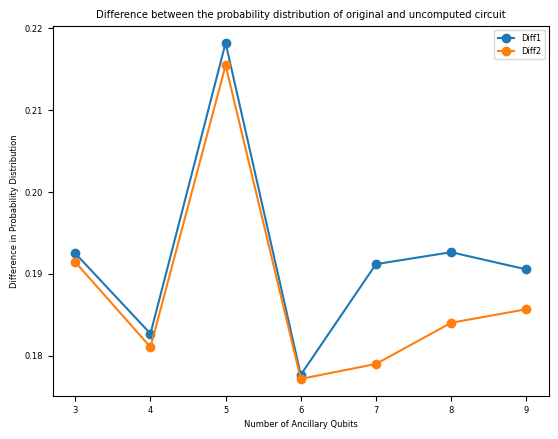

In [121]:
plt.plot(x_axis, ex_comp_avg, marker='o', linestyle='-', label='Diff1')
plt.plot(x_axis, ex_uncomp_avg, marker='o', linestyle='-', label='Diff2')
# plt.setp(lines)
plt.title(f'Difference between the probability distribution of original and uncomputed circuit')
plt.xlabel('Number of Ancillary Qubits')
plt.ylabel('Difference in Probability Distribution')
plt.legend()
plt.show()

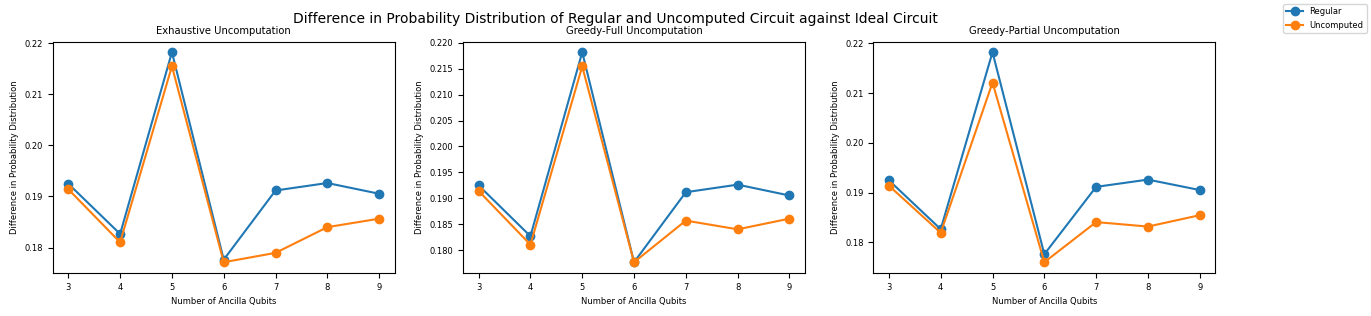

In [122]:
plt.rcParams['font.size'] = 6
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,3))

ax1.plot(x_axis, ex_comp_avg, marker='o', linestyle='-', label='Regular')
ax1.plot(x_axis, ex_uncomp_avg, marker='o', linestyle='-', label='Uncomputed')
ax1.set_title('Exhaustive Uncomputation')
ax1.set_xlabel('Number of Ancilla Qubits')
ax1.set_ylabel('Difference in Probability Distribution')

ax2.plot(x_axis, gf_comp_avg, marker='o', linestyle='-')
ax2.plot(x_axis, gf_uncomp_avg, marker='o', linestyle='-')
ax2.set_title('Greedy-Full Uncomputation')
ax2.set_xlabel('Number of Ancilla Qubits')
ax2.set_ylabel('Difference in Probability Distribution')

ax3.plot(x_axis, gp_comp_avg, marker='o', linestyle='-')
ax3.plot(x_axis, gp_uncomp_avg, marker='o', linestyle='-')
ax3.set_title('Greedy-Partial Uncomputation')
ax3.set_xlabel('Number of Ancilla Qubits')
ax3.set_ylabel('Difference in Probability Distribution')

fig.suptitle('Difference in Probability Distribution of Regular and Uncomputed Circuit against Ideal Circuit', fontsize=10)
fig.legend()

plt.show()
